In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import re
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LogisticRegression

# Code

## Set up

In [2]:
info = pd.read_excel('Brain_networks/Demographic.xlsx')
info['Participant_ID'] = info['Participant_ID'].apply(lambda x: int(re.findall(r'\d+', str(x))[0]))

# Remove duplicates
info = info.drop_duplicates(subset='Participant_ID')

# Reset index (optional)
info = info.reset_index(drop=True)

# Display the result
info.head()

,Participant_ID,ADHD/NT,Gender
0,200,NT,F
1,201,ADHD,F
2,202,NT,F
3,205,NT,F
4,207,NT,F


## Visual

### Data

In [3]:
# Visual
visual_2021 = pd.read_excel('Brain_networks/Network_CC/Visual_2021.xlsx')
visual_2022 = pd.read_excel('Brain_networks/Network_CC/Visual_2022.xlsx')
visual_2023 = pd.read_excel('Brain_networks/Network_CC/Visual_2023.xlsx')

combined_visual = pd.concat([visual_2021, visual_2022, visual_2023], ignore_index=True)
combined_visual.head()

,Participant_ID,Sequence_name,Condition_matfile,Condition,Medial-Occipital,Medial-Lateral(L),Medial-Lateral(R),Occipital-Lateral(L),Occipital-Lateral(R),Lateral(L)-Lateral(R),Averaged_CC
0,200,rsfMRI_HB6,Condition001.mat,rest,0.18123,0.22104,0.032202,0.68723,0.47970,0.97918,0.43010
1,201,rsfMRI_HB6,Condition001.mat,rest,0.44015,0.56515,0.427590,0.84800,0.88916,1.21180,0.73031
2,202,rsfMRI_HB6,Condition001.mat,rest,0.28081,0.21935,0.588840,0.51701,0.67580,0.87309,0.52582
3,205,rsfMRI_HB6,Condition001.mat,rest,0.39404,0.88638,0.519380,0.50584,0.28219,1.08130,0.61152
4,207,rsfMRI_HB6,Condition001.mat,rest,0.44657,0.32933,0.272310,0.47209,0.38130,0.68107,0.43045


In [4]:
merged_visual = combined_visual.merge(info, on='Participant_ID', how='inner')
merged_visual

,Participant_ID,Sequence_name,Condition_matfile,Condition,Medial-Occipital,Medial-Lateral(L),Medial-Lateral(R),Occipital-Lateral(L),Occipital-Lateral(R),Lateral(L)-Lateral(R),Averaged_CC,ADHD/NT,Gender
0,200,rsfMRI_HB6,Condition001.mat,rest,0.18123,0.22104,0.032202,0.68723,0.47970,0.97918,0.43010,NT,F
1,201,rsfMRI_HB6,Condition001.mat,rest,0.44015,0.56515,0.427590,0.84800,0.88916,1.21180,0.73031,ADHD,F
2,202,rsfMRI_HB6,Condition001.mat,rest,0.28081,0.21935,0.588840,0.51701,0.67580,0.87309,0.52582,NT,F
3,205,rsfMRI_HB6,Condition001.mat,rest,0.39404,0.88638,0.519380,0.50584,0.28219,1.08130,0.61152,NT,F
4,207,rsfMRI_HB6,Condition001.mat,rest,0.44657,0.32933,0.272310,0.47209,0.38130,0.68107,0.43045,NT,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,49,flanker_events_twitching,Condition001.mat,task,0.39702,0.59862,0.414060,0.50016,0.54459,0.61968,0.51236,NT,F
164,50,flanker_events_twitching,Condition001.mat,task,0.51244,0.66889,0.811800,0.93864,0.87589,1.51130,0.88649,NT,M
165,51,flanker_events_twitching,Condition001.mat,task,0.66328,0.99676,0.798630,0.74867,0.76243,1.40390,0.89561,NT,F
166,52,flanker_events_twitching,Condition001.mat,task,0.73150,0.70009,0.281980,0.79804,0.24468,0.59390,0.55837,NT,F


In [5]:
merged_visual['Condition'] = merged_visual.apply(
    lambda row: 'task' if row['Sequence_name'] == 'flanker_events'
    else 'task_twitching' if row['Sequence_name'] == 'flanker_events_twitching'
    else 'rest',
    axis=1
)
visual_df = merged_visual.drop(columns=['Sequence_name', 'Condition_matfile'])
visual_df.head()

,Participant_ID,Condition,Medial-Occipital,Medial-Lateral(L),Medial-Lateral(R),Occipital-Lateral(L),Occipital-Lateral(R),Lateral(L)-Lateral(R),Averaged_CC,ADHD/NT,Gender
0,200,rest,0.18123,0.22104,0.032202,0.68723,0.47970,0.97918,0.43010,NT,F
1,201,rest,0.44015,0.56515,0.427590,0.84800,0.88916,1.21180,0.73031,ADHD,F
2,202,rest,0.28081,0.21935,0.588840,0.51701,0.67580,0.87309,0.52582,NT,F
3,205,rest,0.39404,0.88638,0.519380,0.50584,0.28219,1.08130,0.61152,NT,F
4,207,rest,0.44657,0.32933,0.272310,0.47209,0.38130,0.68107,0.43045,NT,F


In [6]:
# ADHD
visual_adhd = visual_df[merged_visual['ADHD/NT'] == 'ADHD'].drop(columns=['ADHD/NT'])
visual_adhd_rest = visual_adhd[visual_adhd['Condition'] == 'rest'].drop(columns=['Condition'])
visual_adhd_task = visual_adhd[visual_adhd['Condition'] == 'task'].drop(columns=['Condition'])
visual_adhd_twitching = visual_adhd[visual_adhd['Condition'] == 'task_twitching'].drop(columns=['Condition'])

# NT
visual_nt = visual_df[merged_visual['ADHD/NT'] == 'NT'].drop(columns=['ADHD/NT'])
visual_nt_rest = visual_nt[visual_nt['Condition'] == 'rest'].drop(columns=['Condition'])
visual_nt_task = visual_nt[visual_nt['Condition'] == 'task'].drop(columns=['Condition'])
visual_nt_twitching = visual_nt[visual_nt['Condition'] == 'task_twitching'].drop(columns=['Condition'])

In [12]:
correlation_columns = visual_df.drop(columns=['Participant_ID', 'Condition', 'Gender', 'ADHD/NT', 'Averaged_CC']).columns.tolist()

X = visual_df[correlation_columns]
y = visual_df['ADHD/NT'].map({'ADHD': 1, 'NT': 0})

model = LogisticRegression(class_weight='balanced')
model.fit(X, y)

LogisticRegression(class_weight='balanced')

In [13]:
# Check model performance
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print(f"Mean AUC: {scores.mean():.3f}")

Mean AUC: 0.667


In [14]:
coefs = model.coef_[0]

importance_df = pd.DataFrame({
    'Correlation': correlation_columns,
    'Coefficient': coefs,
    'Abs_Coefficient': np.abs(coefs)
}).sort_values(by='Abs_Coefficient', ascending=False)
importance_df.head(10)

,Correlation,Coefficient,Abs_Coefficient
1,Medial-Lateral(L),1.315188,1.315188
0,Medial-Occipital,-1.279944,1.279944
5,Lateral(L)-Lateral(R),-0.994033,0.994033
2,Medial-Lateral(R),0.979193,0.979193
3,Occipital-Lateral(L),-0.533471,0.533471
4,Occipital-Lateral(R),-0.122462,0.122462


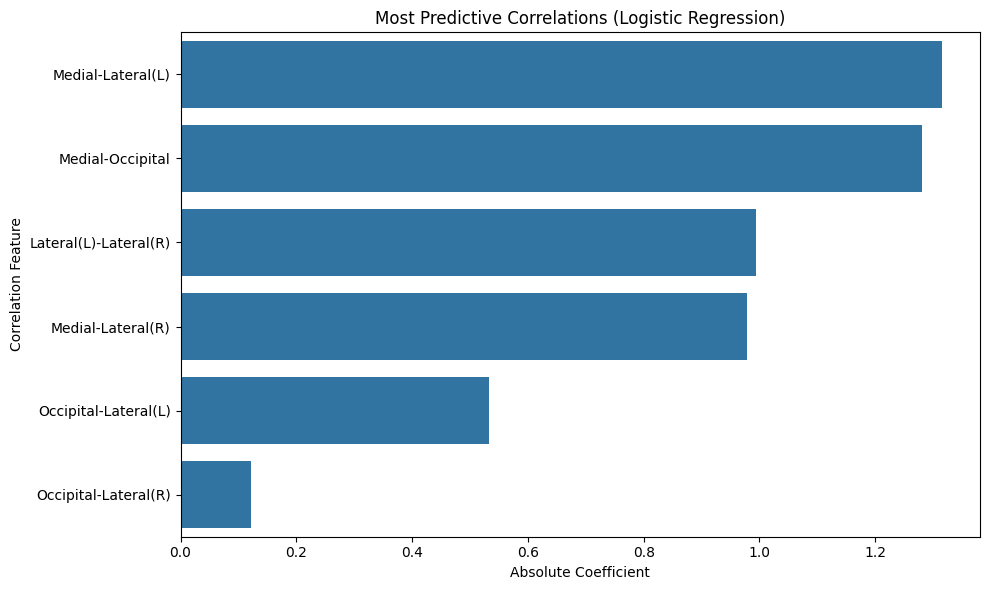

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='Abs_Coefficient', y='Correlation')
plt.title("Most Predictive Correlations (Logistic Regression)")
plt.xlabel("Absolute Coefficient")
plt.ylabel("Correlation Feature")
plt.tight_layout()
plt.show()


In [17]:
from scipy.stats import ttest_ind

results = []

# Loop over each correlation column
for col in correlation_columns:
    adhd_vals = visual_df[visual_df['ADHD/NT'] == 'ADHD'][col]
    nt_vals = visual_df[visual_df['ADHD/NT'] == 'NT'][col]
    
    # Independent t-test, assuming unequal variance (Welch’s t-test)
    t_stat, p_val = ttest_ind(adhd_vals, nt_vals, equal_var=False)
    
    # Store results
    results.append({
        'Correlation': col,
        't_stat': t_stat,
        'p_value': p_val,
        'mean_ADHD': adhd_vals.mean(),
        'mean_NT': nt_vals.mean()
    })

# Convert to DataFrame
ttest_results = pd.DataFrame(results)

# Correct for multiple comparisons (Benjamini-Hochberg FDR)
from statsmodels.stats.multitest import multipletests

ttest_results['p_adjusted'] = multipletests(ttest_results['p_value'], method='fdr_bh')[1]

# Sort by adjusted p-value (most significant first)
ttest_results = ttest_results.sort_values('p_adjusted')

ttest_results.head(10)


,Correlation,t_stat,p_value,mean_ADHD,mean_NT,p_adjusted
0,Medial-Occipital,-2.894361,0.004350,0.362138,0.478442,0.015295
1,Medial-Lateral(L),2.840420,0.005098,0.660895,0.558270,0.015295
2,Medial-Lateral(R),2.149936,0.033220,0.558604,0.471335,0.059650
3,Occipital-Lateral(L),-2.074489,0.039767,0.495868,0.576789,0.059650
4,Occipital-Lateral(R),-1.730093,0.085702,0.401971,0.465152,0.085702
5,Lateral(L)-Lateral(R),-1.775818,0.077765,0.983957,1.073589,0.085702


In [ ]:
correlation_columns = visual_df.drop(columns=['Participant_ID', 'Condition', 'Gender', 'ADHD/NT']).columns.tolist()

results = []

for condition in visual_df['Condition'].unique():
    subset = visual_df[visual_df['Condition'] == condition]
    
    for col in correlation_columns:
        adhd_vals = subset[subset['ADHD/NT'] == 'ADHD'][col]
        nt_vals = subset[subset['ADHD/NT'] == 'NT'][col]
        
        t_stat, p_val = ttest_ind(adhd_vals, nt_vals, equal_var=False)
        
        results.append({
            'Condition': condition,
            'Correlation': col,
            't_stat': t_stat,
            'p_value': p_val
        })

results_df = pd.DataFrame(results)
results_df